# The Movies Dataset



dataset : https://www.kaggle.com/rounakbanik/the-movies-dataset/data  
cleaned : https://drive.google.com/drive/folders/1ZGp7ORu9nA6l3PyNK_H0MGTXNl4sNMsA?usp=sharing

In [1]:
import warnings
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import wordcloud, STOPWORDS 
import glob
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
import scipy.sparse as sp
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
import itertools
import functools
import operator

In [2]:
warnings.filterwarnings("ignore")

In [3]:
movies = pd.read_csv('/Users/davidshi/Downloads/movie/movies.csv', header=0)
movies = movies.replace({np.nan: None}) # replace NaN with None
movies.head()

,id,title,tagline,description,genres,keywords,date,collection,runtime,revenue,...,director,cast,production_companies,production_countries,popularity,average_vote,num_votes,language,imdb_id,poster_url
0,862,Toy Story,None,"Led by Woody, Andy's toys live happily in his ...","animation, comedy, family","jealousy, toy, boy, friendship, friends, rival...",1995-10-30,Toy Story Collection,81,3.73554e+08,...,John Lasseter,"Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",Pixar Animation Studios,United States of America,21.9469,7.7,5415,en,tt0114709,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg
1,8844,Jumanji,Roll the dice and unleash the excitement!,When siblings Judy and Peter discover an encha...,"adventure, fantasy, family","board game, disappearance, based on children's...",1995-12-15,None,104,2.62797e+08,...,Joe Johnston,"Robin Williams, Jonathan Hyde, Kirsten Dunst, ...","TriStar Pictures, Teitler Film, Interscope Com...",United States of America,17.0155,6.9,2413,en,tt0113497,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg
2,15602,Grumpier Old Men,Still Yelling. Still Fighting. Still Ready for...,A family wedding reignites the ancient feud be...,"romance, comedy","fishing, best friend, duringcreditsstinger, ol...",1995-12-22,Grumpy Old Men Collection,101,0,...,Howard Deutch,"Walter Matthau, Jack Lemmon, Ann-Margret, Soph...","Warner Bros., Lancaster Gate",United States of America,11.7129,6.5,92,en,tt0113228,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg
3,31357,Waiting to Exhale,Friends are the people who let you be yourself...,"Cheated on, mistreated and stepped on, the wom...","comedy, drama, romance","based on novel, interracial relationship, sing...",1995-12-22,None,127,8.14522e+07,...,Forest Whitaker,"Whitney Houston, Angela Bassett, Loretta Devin...",Twentieth Century Fox Film Corporation,United States of America,3.85949,6.1,34,en,tt0114885,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg
4,11862,Father of the Bride Part II,Just When His World Is Back To Normal... He's ...,Just when George Banks has recovered from his ...,comedy,"baby, midlife crisis, confidence, aging, daugh...",1995-02-10,Father of the Bride Collection,106,7.65789e+07,...,Charles Shyer,"Steve Martin, Diane Keaton, Martin Short, Kimb...","Sandollar Productions, Touchstone Pictures",United States of America,8.38752,5.7,173,en,tt0113041,/e64sOI48hQXyru7naBFyssKFxVd.jpg


In [4]:
movies.isnull().sum()

id                          0
title                       4
tagline                 25845
description               995
genres                   2524
keywords                14889
date                       88
collection              42054
runtime                   268
revenue                     4
budget                      0
director                  917
cast                     2491
production_companies    12282
production_countries     6496
popularity                  4
average_vote                4
num_votes                   4
language                   11
imdb_id                    17
poster_url                399
dtype: int64

In [5]:
movies.shape

(46628, 21)

In [6]:
def get_year(date):
    year = None
    if date:
        year = date[:4]
    return year

movies['year'] = movies.date.apply(get_year)

 ## Quick Explanatory
 
Which country have twhe most movies produced?

In [7]:
r = movies[~movies['production_countries'].isnull()]

In [8]:
r =list(r['production_countries'].str.split(', '))

In [9]:
flattened_list = functools.reduce(operator.iconcat, r, [])

In [10]:
dd= pd.Series(flattened_list)

Text(0.5, 1.0, 'Production Countries Movie Counts')

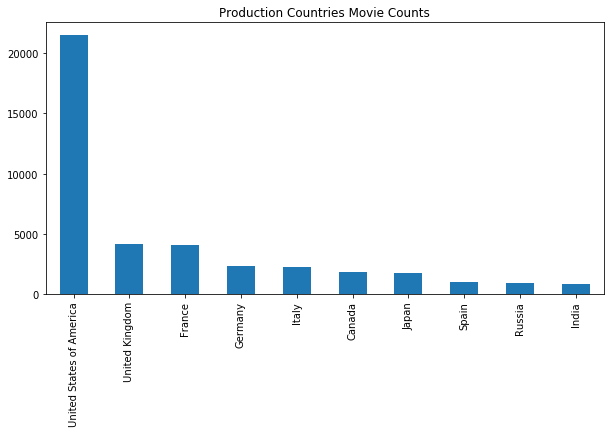

In [11]:
dd.value_counts().head(10).plot(kind='bar',figsize=(10, 5))
plt.title('Production Countries Movie Counts')

## Multilabel Classification on Genre

#### Using keywords column to predict Genre

Each movie is classified as mulitple genres. I am going to predict the muliple genres using keywords column. String are cleaned and vectorized.

In [12]:
df = movies.dropna(subset = ['title','genres','description'])

In [13]:
mlb = MultiLabelBinarizer()
mlb.fit(df['genres'])

y = mlb.transform(df['genres'])

In [14]:
def cleanstring(x):
    
    x = x.translate(str.maketrans('', '', string.punctuation))
    x = [c for c in x.split() if c.lower() not in stopwords.words('english')]
    return " ".join(x)

In [15]:
def removepunc(x):
    
    x = x.translate(str.maketrans('', '', string.punctuation))
    return x

In [16]:
df['keywords'] = df['keywords'].astype(str)

In [17]:
X=df['keywords'].apply(removepunc)
X=TfidfVectorizer('english',max_df=0.8,lowercase=True).fit_transform(X)
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2,random_state=0)

In [18]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)
results = pd.DataFrame(columns = ['F1 Score']) 

In [19]:
for i in range (10):
    Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2,random_state=i)
    clf.fit(Xtrain,ytrain)
    pred=clf.predict(Xtest)
    results=results.append({'F1 Score' : f1_score(ytest,pred,average="micro")}, ignore_index=True)

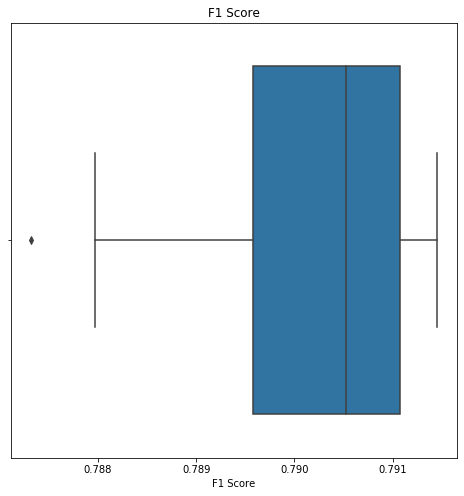

In [20]:
plt.figure(figsize=(8,8))
plt.title('F1 Score')
sns.boxplot(x=results['F1 Score'])

#### Using description column to predict Genre

In [21]:
X2 = df['description'].astype(str)
X2 = TfidfVectorizer('english',max_df=0.8,lowercase=True).fit_transform(X2)

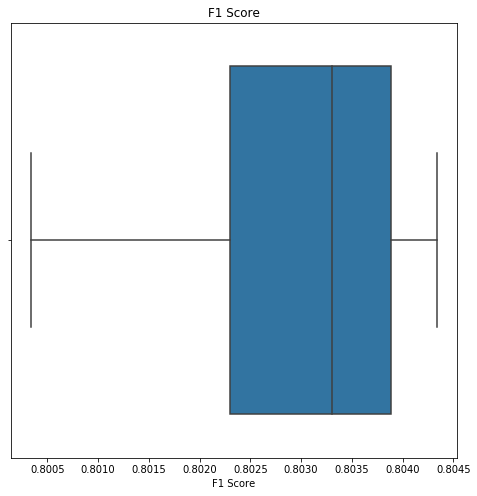

In [22]:
results = pd.DataFrame(columns = ['F1 Score']) 
for i in range (10):
    Xtrain,Xtest,ytrain,ytest = train_test_split(X2,y,test_size=0.2,random_state=i)
    clf.fit(Xtrain,ytrain)
    pred=clf.predict(Xtest)
    results=results.append({'F1 Score' : f1_score(ytest,pred,average="micro")}, ignore_index=True)
plt.figure(figsize=(8,8))
plt.title('F1 Score')
sns.boxplot(x=results['F1 Score'])

## movie recommendations by rating and popularity

Although data already provides average rating, this can be quite misleading. When comparing two average ratings the consideration of number of votes is very important. Movie 1 can have a rating of 9.0 with only 3 votes compared to Movie 2 having a rating of 8.0 with 50 votes. In this situation Movie 1's rating is very biased due to the low amount of voters. To tackle this problem IMBD have a weight rating formula.

Weighted Rating = (vR)/(v+m) + (mC)/(v+m)

m = minimum votes to be listed in chart ( we will assume movies with 85 percentile number of voters to be relevant)  
C = mean of average rating for all movies  
R = average rating for specific movie  
v = number of votes for specific movie

In [23]:
m=df['num_votes'].quantile(0.85)
C=df['average_vote'].mean()
df2=df[df['num_votes']>m]

In [24]:
def weightedrating(j,m=m,C=C):
    v=j['num_votes']
    R=j['average_vote']
    
    return (v*R)/(v+m) + (m*C)/(v+m)

In [25]:
df2['imbd_wr']=df.apply(weightedrating,axis=1)

In [26]:
df.shape

(43372, 22)

In [27]:
df2.shape

(6482, 23)

In [28]:
df.set_index('id')
df2.set_index('id')
df['imbd_wr']=df2['imbd_wr']

In [29]:
df['genres']=df['genres'].str.split(', ')
s = df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_df = df.drop('genres', axis=1).join(s)

This seperates the genre column by listing movies duplicately in dataframe. Example would be:  

--before--  
movie 1 : [comedy,dance]        

--after--   
movie 1 : [comedy]  
movie 1 : [dance]

In [30]:
def genre_rec(genre,method):
    if(method == 'popularity'):
        x = gen_df[gen_df['genre']==genre]
        x=x.reset_index(drop=True)
        return x[['title','year',method]].sort_values(by=[method],ascending=False).head(20)
    
    if(method =='imbd_wr'):
        x = gen_df[gen_df['genre']==genre]
        x=x.reset_index(drop=True)
        return x[['title','year',method]].sort_values(by=[method],ascending=False).head(20)

In [31]:
genre_rec('horror','imbd_wr')

,title,year,imbd_wr
53,Psycho,1960,8.206322
56,The Shining,1980,8.045797
51,Alien,1979,7.857514
168,The Thing,1982,7.690211
50,Aliens,1986,7.646700
4230,Train to Busan,2016,7.532656
4679,Black Mirror: White Christmas,2014,7.523496
87,Jaws,1975,7.440498
834,Shaun of the Dead,2004,7.437046
140,The Exorcist,1973,7.424285


In [32]:
genre_rec('comedy','popularity')

,title,year,popularity
9119,Minions,2015,547.488
7437,Big Hero 6,2014,213.85
8025,Deadpool,2016,187.86
8026,Guardians of the Galaxy Vol. 2,2017,185.331
8024,Pirates of the Caribbean: Dead Men Tell No Tales,2017,133.828
12415,Captain Underpants: The First Epic Movie,2017,88.5612
127,Forrest Gump,1994,48.3072
9113,Ted 2,2015,42.0615
11283,Now You See Me 2,2016,39.5407
785,Life Is Beautiful,1997,39.395


Text(0.5, 1.0, 'Genre Average Ratings')

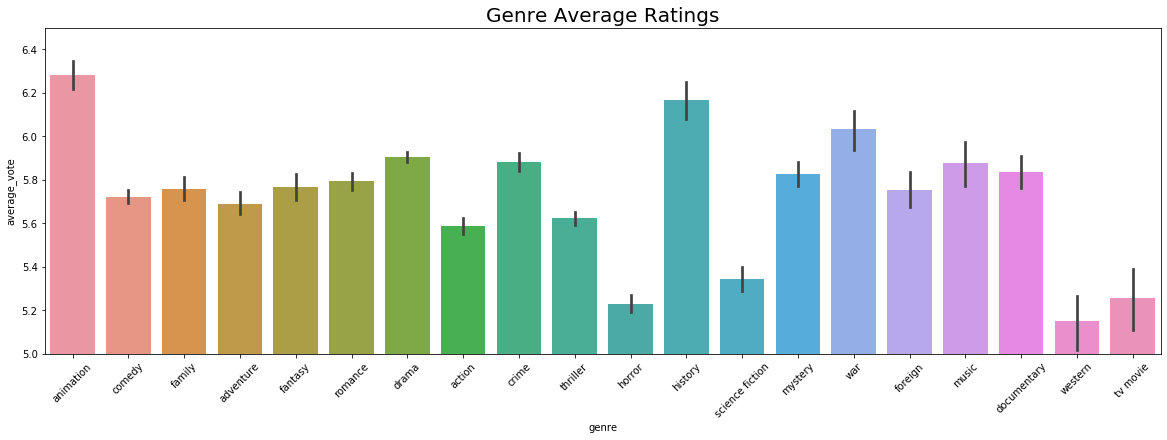

In [33]:
plt.figure(figsize=(20,6))
plt.ylim(5,6.5)
sns.barplot(x='genre',y='average_vote',data=gen_df)
plt.xticks(rotation=45)
plt.title('Genre Average Ratings', fontsize=20)

## movie recommendations by plot similarity



In [34]:
tfidf_matrix = TfidfVectorizer(stop_words='english').fit_transform(df['description'])

In [35]:
tfidf_matrix.shape

(43372, 73186)

description column is vectorized and transformed into TF-IDF matrix. 70000+ words describing 40000+ movies.

In [36]:
df = df.reset_index(drop=True)

In [37]:
indices = pd.Series(df.index, index=df['title'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [38]:
indices ##movie array

title
Toy Story                          0
Jumanji                            1
Grumpier Old Men                   2
Waiting to Exhale                  3
Father of the Bride Part II        4
                               ...  
Caged Heat 3000                43367
Robin Hood                     43368
Subdue                         43369
Century of Birthing            43370
Betrayal                       43371
Length: 43372, dtype: int64

redoing index so index can match between movie array and cosine similiarty matrix. Calculating the dot product / scalar product of TF-IDF vectorized data will give cosine similiarity score.

In [39]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of movie 
    idx = indices[title]

    # pair similarity scores 
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

   
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return df['title'].iloc[movie_indices]

In [40]:
get_recommendations('Minions')

20713                          Despicable Me 2
18175                      What's Up, Scarlet?
10463                A Story of Floating Weeds
30034                  The Mother Of Invention
16020                              Madam Satan
30908                        The Invisible Boy
302                    Stuart Saves His Family
43091                                   Banana
5618                             Soul Assassin
7958     Sherlock Holmes and the Secret Weapon
Name: title, dtype: object

In [41]:
get_recommendations('Toy Story')

15210                                     Toy Story 3
2938                                      Toy Story 2
23852                                       Small Fry
10200                          The 40 Year Old Virgin
23218                     Andy Hardy's Blonde Trouble
37146    Superstar: The Life and Times of Andy Warhol
40952    Andy Peters: Exclamation Mark Question Point
8243                                        The Champ
1047                            Rebel Without a Cause
26371                      Life Begins for Andy Hardy
Name: title, dtype: object

movie recommendation by cast, keywords, genre. Using count vectorizer to weigh frequency of repeating cast and repeating keywords in multiple movies.

In [42]:
df.isnull().sum()

id                          0
title                       0
tagline                 22870
description                 0
genres                      0
keywords                    0
date                       23
collection              38914
runtime                     0
revenue                     0
budget                      0
director                  539
cast                     1713
production_companies     9744
production_countries     4687
popularity                  0
average_vote                0
num_votes                   0
language                    9
imdb_id                    10
poster_url                168
year                       23
imbd_wr                 36890
dtype: int64

In [43]:
df = df.dropna(subset = ['cast'])
df = df.reset_index(drop=True)
indices = pd.Series(df.index, index=df['title'])

In [44]:
df['cast'].apply(removepunc)

0        Tom Hanks Tim Allen Don Rickles Jim Varney Wal...
1        Robin Williams Jonathan Hyde Kirsten Dunst Bra...
2        Walter Matthau Jack Lemmon AnnMargret Sophia L...
3        Whitney Houston Angela Bassett Loretta Devine ...
4        Steve Martin Diane Keaton Martin Short Kimberl...
                               ...                        
41654    Lisa Boyle Kena Land Zaneta Polard Don Yanan D...
41655    Patrick Bergin Uma Thurman David Morrissey Jür...
41656              Leila Hatami Kourosh Tahami Elham Korda
41657    Angel Aquino Perry Dizon Hazel Orencio Joel To...
41658    Erika Eleniak Adam Baldwin Julie du Page James...
Name: cast, Length: 41659, dtype: object

In [45]:
df['keywords'].apply(removepunc)

0        jealousy toy boy friendship friends rivalry bo...
1        board game disappearance based on childrens bo...
2         fishing best friend duringcreditsstinger old men
3        based on novel interracial relationship single...
4        baby midlife crisis confidence aging daughter ...
                               ...                        
41654                                                 None
41655                                                 None
41656                                          tragic love
41657                                    artist play pinoy
41658                                                 None
Name: keywords, Length: 41659, dtype: object

In [46]:
def listToString(s): 
    str1 = " " 
    return (str1.join(s))

In [47]:
df['genres'].apply(listToString)

0         animation comedy family
1        adventure fantasy family
2                  romance comedy
3            comedy drama romance
4                          comedy
                   ...           
41654             science fiction
41655        drama action romance
41656                drama family
41657                       drama
41658       action drama thriller
Name: genres, Length: 41659, dtype: object

In [48]:
X = df['cast'].apply(removepunc) + df['keywords'].apply(removepunc) + df['genres'].apply(listToString)

count_matrix = CountVectorizer('english').fit_transform(X)

cosine_sim2 = cosine_similarity(count_matrix,count_matrix)

In [49]:
get_recommendations('Minions',cosine_sim2)

40104                              Binky Nelson Unpacified
25610                              The Wind in the Willows
24511                                       Tactical Force
40487                                      Despicable Me 3
9190                      High Roller: The Stu Ungar Story
9102                                           Kung Phooey
15246                                  Life During Wartime
22831                      A Good Job: Stories of the FDNY
29294    Michael Jackson Dangerous Tour - Bucharest - 1992
31477                             N: The Madness Of Reason
Name: title, dtype: object

In [50]:
get_recommendations('Toy Story', cosine_sim2)

2916                        Toy Story 2
14977                       Toy Story 3
24332        Toy Story That Time Forgot
20895              Toy Story of Terror!
23205                 Hawaiian Vacation
23206                         Small Fry
24330                   Partysaurus Rex
2608                                Big
6100     Gigantic (A Tale Of Two Johns)
1748                     Small Soldiers
Name: title, dtype: object

Using different columns to get recommendations did yield different results

### movie recommendations by user history & plot similarity

Used user rating csv to find top movies of specific users and recommended movies based on that.

In [141]:
user = pd.read_csv('/Users/davidshi/Downloads/movie/ratings_small.csv')

In [142]:
user

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


User data contains rows of user ratings. rating column (1-5). 

In [143]:
links = pd.read_csv('/Users/davidshi/Downloads/movie/links.csv')

In [144]:
links

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
45838,176269,6209470,439050.0
45839,176271,2028550,111109.0
45840,176273,303758,67758.0
45841,176275,8536,227506.0


links df have movieId and tmbdid equivalent. Need links df to get movie title for user df  

In [145]:
user = user.merge(links[['movieId','tmdbId']],on='movieId',how='left')

In [146]:
user = user.rename(columns={'tmdbId':'id'})
user = user.drop(columns =['movieId'])

In [147]:
user

,userId,rating,timestamp,id
0,1,2.5,1260759144,9909.0
1,1,3.0,1260759179,11360.0
2,1,3.0,1260759182,819.0
3,1,2.0,1260759185,1103.0
4,1,4.0,1260759205,11216.0
...,...,...,...,...
99999,671,2.5,1065579370,25461.0
100000,671,4.0,1065149201,51927.0
100001,671,4.0,1070940363,604.0
100002,671,2.5,1070979663,1088.0


In [148]:
user = user.merge(movies[['id','title','average_vote']],on='id',how='left')

In [149]:
user

,userId,rating,timestamp,id,title,average_vote
0,1,2.5,1260759144,9909.0,Dangerous Minds,6.4
1,1,3.0,1260759179,11360.0,Dumbo,6.8
2,1,3.0,1260759182,819.0,Sleepers,7.3
3,1,2.0,1260759185,1103.0,Escape from New York,6.9
4,1,4.0,1260759205,11216.0,Cinema Paradiso,8.2
...,...,...,...,...,...,...
100311,671,2.5,1065579370,25461.0,Raising Victor Vargas,7.8
100312,671,4.0,1065149201,51927.0,Stevie,6.7
100313,671,4.0,1070940363,604.0,The Matrix Reloaded,6.7
100314,671,2.5,1070979663,1088.0,Whale Rider,7.1


In [150]:
user.isnull().sum()

userId            0
rating            0
timestamp         0
id              106
title           194
average_vote    194
dtype: int64

In [151]:
user = user.dropna(subset = ['id','title'])

In [152]:
user

,userId,rating,timestamp,id,title,average_vote
0,1,2.5,1260759144,9909.0,Dangerous Minds,6.4
1,1,3.0,1260759179,11360.0,Dumbo,6.8
2,1,3.0,1260759182,819.0,Sleepers,7.3
3,1,2.0,1260759185,1103.0,Escape from New York,6.9
4,1,4.0,1260759205,11216.0,Cinema Paradiso,8.2
...,...,...,...,...,...,...
100311,671,2.5,1065579370,25461.0,Raising Victor Vargas,7.8
100312,671,4.0,1065149201,51927.0,Stevie,6.7
100313,671,4.0,1070940363,604.0,The Matrix Reloaded,6.7
100314,671,2.5,1070979663,1088.0,Whale Rider,7.1


In [153]:
user.userId.value_counts().min()

19

Users rated atleast 19 movies

In [154]:
user = user.sort_values(by=['userId','rating','average_vote'],ascending=[True,False,False]).groupby('userId').head(5)

In [155]:
#get top 5 movies for user

def getTopMov(uid) :
    return user[user['userId']==uid].title.values
    
    

In [156]:
#recommendation by finding 10 highest pair similartiy from list of movies

def get_recommendations2(title,cosine_sim):
    sim_scores=[]
    for i in title:
        # Get the index of movie 
        idx = indices[i]

        # pair similarity scores 
        sim_scores = sim_scores + list(enumerate(cosine_sim[idx]))

    # Sort the movies based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

   
    sim_scores = sim_scores[5:15]
    movie_indices = [i[0] for i in sim_scores]
    return df['title'].iloc[movie_indices]

In [157]:
getTopMov(10)

array(['The Usual Suspects', 'The Matrix', 'Sling Blade',
       'My Own Private Idaho', 'Runaway Train'], dtype=object)

In [158]:
get_recommendations2(getTopMov(10), cosine_sim)

10430                The White Countess
6441                    Day of the Dead
6567                Charlotte Sometimes
22669                        Camouflage
2470     Invasion of the Body Snatchers
5279               The Care Bears Movie
27134                   That Sugar Film
8297               King Solomon's Mines
4250                           Critters
11502                Meet the Robinsons
Name: title, dtype: object

In [159]:
#recommendation by finding 3 highest pair similartiy for each movie in list

def get_recommendations3(title,cosine_sim):
    sim_scores_final =[]
    for i in title:
        # Get the index of movie 
        idx = indices[i]

        # pair similarity scores 
        sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores_final = sim_scores_final + sim_scores[1:4]
        
    
    movie_indices = [i[0] for i in sim_scores_final]
    
    return df['title'].iloc[movie_indices]

In [160]:
getTopMov(10)

array(['The Usual Suspects', 'The Matrix', 'Sling Blade',
       'My Own Private Idaho', 'Runaway Train'], dtype=object)

In [161]:
get_recommendations3(getTopMov(10),cosine_sim)

8914                              Gummo
32264                         Pestonjee
27965                         The Hands
6567                Charlotte Sometimes
22669                        Camouflage
27134                   That Sugar Film
10430                The White Countess
6441                    Day of the Dead
2470     Invasion of the Body Snatchers
4896                          The Arena
6315                        Big Trouble
18695               Under African Skies
26883                             Nymph
12310                   Are You Scared?
31721                     OceanWorld 3D
Name: title, dtype: object